In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from keras.layers import Layer, Input, Dropout, Conv2D, Activation, add, UpSampling2D, Conv2DTranspose, Flatten
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization, InputSpec
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.models import Model
from keras.engine.topology import Network

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from progress.bar import Bar
import datetime
import time
import json
import csv
import sys
import os

import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
#from helper_funcs import *
#from helper_funcs2 import *
from helper_funcs3 import *

In [4]:
#image_folder = 'brain' #skullstripped
#image_folder = 'brainv3'
#image_folder = 'brainv4' #bounded
#image_folder = 'healthy' #anomaly detection

#image_folder = 'customnoss'
image_folder = 'custom-ncct2adc' #NCCT 2 ADC SS
#image_folder = 'custom-adc2dwi'
#image_folder = 'custom-ncct2dwi'

#image_folder = 'customnoss-ncct2dwi'
#image_folder = 'customnoss-adc2dwi'
#image_folder = 'customnoss-ncct2adc'

data = load_data(subfolder=image_folder)

In [5]:
opt = {}

# Data
opt['channels'] = data["nr_of_channels"]
opt['img_shape'] = data["image_size"] + (opt['channels'],)
print('Image shape: ', opt['img_shape'])

opt['A_train'] = data["trainA_images"]
opt['B_train'] = data["trainB_images"]
opt['A_test'] = data["testA_images"]
opt['B_test'] = data["testB_images"]
opt['testA_image_names'] = data["testA_image_names"]
opt['testB_image_names'] = data["testB_image_names"]

opt['trainA_image_names'] = data["trainA_image_names"]
opt['trainB_image_names'] = data["trainB_image_names"]

#opt['CTFOSCAL_images'] = data["CTFOSCAL_images"]
#opt['CTFOSCAL_image_names'] = data["CTFOSCAL_image_names"]
#opt['CTHEALTHY_images'] = data["CTHEALTHY_images"]
#opt['CTHEALTHY_image_names'] = data["CTHEALTHY_image_names"]

print(opt['A_train'].shape)
print(opt['B_train'].shape)

#print(opt['CTFOSCAL_images'].shape)
#print(len(opt['CTFOSCAL_image_names']))
#print(opt['CTHEALTHY_images'].shape)
#print(len(opt['CTHEALTHY_image_names']))


opt['paired_data'] = False


# Training parameters
opt['lambda_ABA'] = 10.0  # Cyclic loss weight A_2_B
opt['lambda_BAB'] = 10.0  # Cyclic loss weight B_2_A
opt['lambda_adversarial'] = 1.0  # Weight for loss from discriminator guess on synthetic images
opt['learning_rate_D'] = 2e-4
opt['learning_rate_G'] = 2e-4
opt['generator_iterations'] = 3  # Number of generator training iterations in each training loop
opt['discriminator_iterations'] = 1  # Number of discriminator training iterations in each training loop
opt['synthetic_pool_size'] = 50  # Size of image pools used for training the discriminators
opt['beta_1'] = 0.5  # Adam parameter
opt['beta_2'] = 0.999  # Adam parameter
opt['batch_size'] = 16  # Number of images per batch
opt['epochs'] = 100  # Choose multiples of 20 since the models are saved each 20th epoch


# Output parameters
opt['save_models'] = True  # Save or not the generator and discriminator models
opt['save_training_img'] = True  # Save or not example training results or only tmp.png
opt['save_training_img_interval'] = 1  # Number of epoch between saves of intermediate training results
opt['self.tmp_img_update_frequency'] = 3  # Number of batches between updates of tmp.png


# Architecture parameters
opt['use_instance_normalization'] = True  # Use instance normalization or batch normalization
opt['use_dropout'] = False  # Dropout in residual blocks
opt['use_bias'] = True  # Use bias
opt['use_linear_decay'] = True  # Linear decay of learning rate, for both discriminators and generators
opt['decay_epoch'] = 100  # The epoch where the linear decay of the learning rates start
opt['use_patchgan'] = True  # PatchGAN - if false the discriminator learning rate should be decreased
opt['use_resize_convolution'] = False  # Resize convolution - instead of transpose convolution in deconvolution layers (uk) - can reduce checkerboard artifacts but the blurring might affect the cycle-consistency
opt['discriminator_sigmoid'] = True  # Add a final sigmoid activation to the discriminator


# Tweaks
opt['REAL_LABEL'] = 1.0  # Use e.g. 0.9 to avoid training the discriminators to zero loss

Image shape:  (256, 256, 1)
(1182, 256, 256, 1)
(1182, 256, 256, 1)


In [6]:
# Discriminator layers
def ck(model, opt, x, k, use_normalization, use_bias):
    x = Conv2D(filters=k, kernel_size=4, strides=2, padding='same', use_bias=use_bias)(x)
    if use_normalization:
        x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)
    return x

# First generator layer
def c7Ak(model, opt, x, k):
    x = Conv2D(filters=k, kernel_size=7, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Downsampling
def dk(model, opt, x, k):  # Should have reflection padding
    x = Conv2D(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Residual block
def Rk(model, opt, x0):
    k = int(x0.shape[-1])

    # First layer
    x = ReflectionPadding2D((1,1))(x0)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)

    if opt['use_dropout']:
        x = Dropout(0.5)(x)

    # Second layer
    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    # Merge
    x = add([x, x0])

    return x

# Upsampling
def uk(model, opt, x, k):
    # (up sampling followed by 1x1 convolution <=> fractional-strided 1/2)
    if opt['use_resize_convolution']:
        x = UpSampling2D(size=(2, 2))(x)  # Nearest neighbor upsampling
        x = ReflectionPadding2D((1, 1))(x)
        x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    else:
        x = Conv2DTranspose(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)  # this matches fractionally stided with stride 1/2
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x


def build_discriminator(model, opt, name=None):
    # Input
    input_img = Input(shape=opt['img_shape'])

    # Layers 1-4
    x = ck(model, opt, input_img, 64, False, True) #  Instance normalization is not used for this layer)
    x = ck(model, opt, x, 128, True, opt['use_bias'])
    x = ck(model, opt, x, 256, True, opt['use_bias'])
    x = ck(model, opt, x, 512, True, opt['use_bias'])

    # Layer 5: Output
    if opt['use_patchgan']:
        x = Conv2D(filters=1, kernel_size=4, strides=1, padding='same', use_bias=True)(x)
    else:
        x = Flatten()(x)
        x = Dense(1)(x)

    if opt['discriminator_sigmoid']:
        x = Activation('sigmoid')(x)

    return Model(inputs=input_img, outputs=x, name=name)

def build_generator(model, opt, name=None):
    # Layer 1: Input
    input_img = Input(shape=opt['img_shape'])
    x = ReflectionPadding2D((3, 3))(input_img)
    x = c7Ak(model, opt, x, 32)

    # Layer 2-3: Downsampling
    x = dk(model, opt, x, 64)
    x = dk(model, opt, x, 128)

    # Layers 4-12: Residual blocks
    for _ in range(4, 13):
        x = Rk(model, opt, x)

    # Layer 13:14: Upsampling
    x = uk(model, opt, x, 64)
    x = uk(model, opt, x, 32)

    # Layer 15: Output
    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(opt['channels'], kernel_size=7, strides=1, padding='valid', use_bias=True)(x)
    x = Activation('tanh')(x)

    return Model(inputs=input_img, outputs=x, name=name)


#@title Generator
from keras import layers

def u_block(input_tensor, 
            encoder_num_filters=[64, 128, 256, 512, 512, 512, 512, 512],
            decoder_num_filters=[512, 1024, 1024, 1024, 1024, 512, 256, 128],
            use_instance_norm=True,
            block_prefix=''):
    
    x = input_tensor
    encoder_blocks_outputs = []
    
    # Encoder path.
    for i, num_filters in enumerate(encoder_num_filters):
        x = layers.Conv2D(num_filters, 
                          kernel_size=4, 
                          strides=2, 
                          padding='same', 
                          name=f'{block_prefix}_EncoderBlock{i+1}-Conv')(x)
        if use_instance_norm:
            x = InstanceNormalization(name=f'{block_prefix}_EncoderBlock{i+1}-Instancenorm')(x)
        else:
            x = layers.BatchNormalization(name=f'{block_prefix}_EncoderBlock{i+1}-Batchnorm')(x)
        x = layers.Activation('relu', name=f'{block_prefix}_EncoderBlock{i+1}-ReLU')(x)
        
        # Append the encoder blocks outputs, except for the last one.
        if i != len(encoder_num_filters) - 1: 
            encoder_blocks_outputs.append(x)

    # Decoder path.
    for i, num_filters in enumerate(decoder_num_filters):
        x = layers.Conv2DTranspose(
            num_filters, 
            kernel_size=(4, 4), 
            strides=(2, 2), 
            padding='same',
            name=f'{block_prefix}_DecoderBlock{i+1}-TransposedConv'
        )(x)
        x = layers.Activation('relu', name=f'{block_prefix}_DecoderBlock{i+1}-ReLU')(x)

        # All the decoder blocks have concatenate the encoder block output with
        # the same spatial dimentions except for the last one.
        if i != len(decoder_num_filters) - 1: 
            x = layers.Concatenate(
                name=f'{block_prefix}_DecoderBlock{i+1}-Concat'
            )([encoder_blocks_outputs[-(i + 1)], x])

    # Last operation: 1x1 conv to map the image to the input n_channels.
    x = layers.Conv2D(1,   #input_tensor.shape[-1]
                      kernel_size=(1, 1), 
                      name=f'{block_prefix}_Decoder-Conv1x1')(x)
    output = layers.Activation('tanh', name=f'{block_prefix}_Decoder-Tanh')(x)

    return output

def build_casnet_generator(input_shape=(256, 256, 1), 
                           n_blocks=2, 
                           use_instance_norm=True,
                           name=None):
    """Create a CasNet Generator using UBlocks"""
    input_tensor = Input(shape=input_shape)
    x = input_tensor
    for i in range(n_blocks):
        x = u_block(x, block_prefix=f'UBlock{i+1}', use_instance_norm=use_instance_norm)
    
    return Model(inputs=input_tensor, outputs=x, name=name)


# Mean squared error
def mse(y_true, y_pred):
    loss = tf.reduce_mean(tf.squared_difference(y_pred, y_true))
    return loss

# Mean absolute error
def mae(y_true, y_pred):
    loss = tf.reduce_mean(tf.abs(y_pred - y_true))
    return loss


model = {}

# Normalization
model['normalization'] = InstanceNormalization

# Optimizers
model['opt_D'] = Adam(opt['learning_rate_D'], opt['beta_1'], opt['beta_2'])
model['opt_G'] = Adam(opt['learning_rate_G'], opt['beta_1'], opt['beta_2'])

# Build discriminators
D_A = build_discriminator(model, opt, name='D_A')
D_B = build_discriminator(model, opt, name='D_B')

# Define discriminator models
image_A = Input(shape=opt['img_shape'])
print(image_A.shape)
image_B = Input(shape=opt['img_shape'])
guess_A = D_A(image_A)
guess_B = D_B(image_B)
model['D_A'] = Model(inputs=image_A, outputs=guess_A, name='D_A_model')
model['D_B'] = Model(inputs=image_B, outputs=guess_B, name='D_B_model')

# Compile discriminator models
loss_weights_D = [0.5]  # 0.5 since we train on real and synthetic images
model['D_A'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)
model['D_B'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)

# Use containers to make a static copy of discriminators, used when training the generators
model['D_A_static'] = Network(inputs=image_A, outputs=guess_A, name='D_A_static_model')
model['D_B_static'] = Network(inputs=image_B, outputs=guess_B, name='D_B_static_model')

# Do not update discriminator weights during generator training
model['D_A_static'].trainable = False
model['D_B_static'].trainable = False

# Build generators
#model['G_A2B'] = build_generator(model, opt, name='G_A2B_model')
#model['G_B2A'] = build_generator(model, opt, name='G_B2A_model')

model['G_A2B'] = build_casnet_generator(input_shape=(256,256,1), n_blocks=1, name='G_A2B_model')
model['G_B2A'] = build_casnet_generator(input_shape=(256,256,1), n_blocks=1, name='G_B2A_model')

print("G_A2B")
#model['G_A2B'].summary()
#print("G_B2A")
#model['G_B2A'].summary()

# Define full CycleGAN model, used for training the generators
real_A = Input(shape=opt['img_shape'], name='real_A')
real_B = Input(shape=opt['img_shape'], name='real_B')
synthetic_B = model['G_A2B'](real_A)
synthetic_A = model['G_B2A'](real_B)
dB_guess_synthetic = model['D_B_static'](synthetic_B)
dA_guess_synthetic = model['D_A_static'](synthetic_A)
reconstructed_A = model['G_B2A'](synthetic_B)
reconstructed_B = model['G_A2B'](synthetic_A)

# Compile full CycleGAN model
model_outputs = [reconstructed_A, reconstructed_B,
                 dB_guess_synthetic, dA_guess_synthetic]
compile_losses = [mae, mae,
                  mse, mse]
compile_weights = [opt['lambda_ABA'], opt['lambda_BAB'],
                   opt['lambda_adversarial'], opt['lambda_adversarial']]

model['G_model'] = Model(inputs=[real_A, real_B],
                     outputs=model_outputs,
                     name='G_model')

model['G_model'].compile(optimizer=model['opt_G'],
                     loss=compile_losses,
                     loss_weights=compile_weights)

W0707 10:15:16.442987 140348234352448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 10:15:16.443895 140348234352448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 10:15:16.446497 140348234352448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 10:15:16.634797 140348234352448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



(?, 256, 256, 1)
G_A2B


<div style="height:100px;"></div>

### Load weights

In [7]:
folder = "20230207-121838-custom-ublocks" #NCCT to ADC ss
#folder = "20230303-140156-custom-ncct2dwi" #20230303-140156-custom-ncct2dwi ---> NCCT to DWI ublocks ss (again with 11 epochs)
#folder = "20230303-161154-custom-adc2dwi" #20230303-161154-custom-adc2dwi ---> ADC to DWI


#folder = "20230222-111734-customnoss" #20230222-111734-customnoss ---> NCCT to DWI ublocks
#folder = "20230223-080355-customnoss" #20230223-080355-customnoss ---> ADC to DWI ublocks

###########folder = "20230314-195952-customnoss-ncct2adc" #NCCT to ADC customnoss ----> TO RUN AGAIN !!!!

ep = 100
checkpoint_path1 = "/data/saved_models/"+folder+"/G_A2B_model_weights_epoch_"+str(ep)+".hdf5"
checkpoint_path2 = "/data/saved_models/"+folder+"/G_B2A_model_weights_epoch_"+str(ep)+".hdf5"
model["G_A2B"].load_weights(checkpoint_path1)
model["G_B2A"].load_weights(checkpoint_path2)
print("DONE!")

W0707 10:15:22.603755 140348234352448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0707 10:15:22.604469 140348234352448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



DONE!


train_048_ncct_16.png
0.02562570571899414 seg.


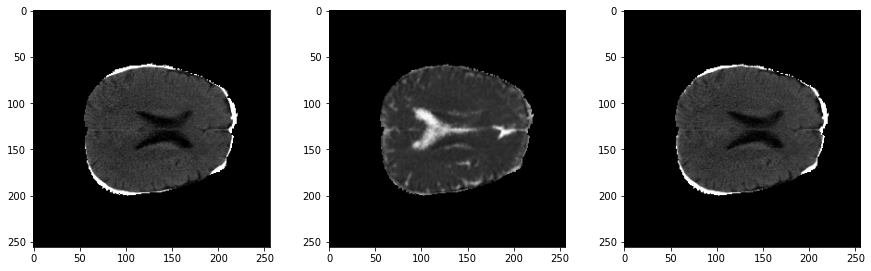

In [19]:
k=7

print(opt['testA_image_names'][k])
pathimg = "data/custom-ncct2adc/testA/"+opt['testA_image_names'][k]
img = mpimg.imread(pathimg)
img = (img*2)-1


t0 = time.time()
synthetic_images_B = model['G_A2B'].predict(img[np.newaxis,:,:,:1])
print(time.time()-t0, "seg.")

reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)
plt.figure(figsize=(15,20))
plt.subplot(4,3,1)
plt.imshow(opt['A_test'][k][:,:,0], cmap="gray")
plt.subplot(4,3,2)
plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
plt.subplot(4,3,3)
plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")
plt.show()

train_048_adc_15.png
0.02544093132019043 seg.


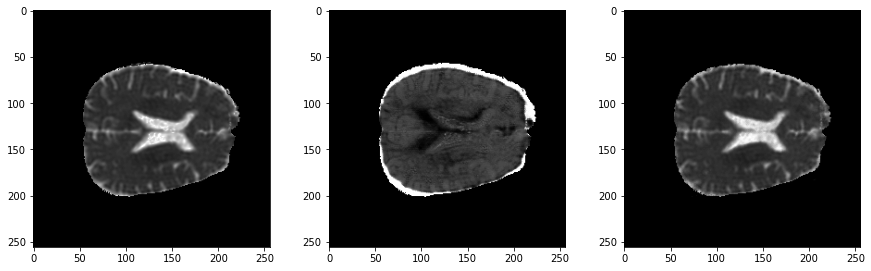

In [22]:
k=5

print(opt['testB_image_names'][k])
pathimg = "data/custom-ncct2adc/testB/"+opt['testB_image_names'][k]
img = mpimg.imread(pathimg)
img = (img*2)-1

t0 = time.time()
synthetic_images_A = model['G_B2A'].predict(img[np.newaxis,:,:,:1])
print(time.time()-t0, "seg.")

reconstructed_image_B = model['G_A2B'].predict(synthetic_images_A)
plt.figure(figsize=(15,20))
plt.subplot(4,3,1)
plt.imshow(opt['B_test'][k][:,:,0], cmap="gray")
plt.subplot(4,3,2)
plt.imshow(synthetic_images_A[0,:,:,0], cmap="gray")
plt.subplot(4,3,3)
plt.imshow(reconstructed_image_B[0,:,:,0], cmap="gray")
plt.show()

<br><br><br>